# image-classifier

In [1]:
import os
import abcli
from abcli import string
from abcli.plugins import gpu
import image_classifier
from abcli import logging
import logging

logger = logging.getLogger(__name__)

logger.info(f"using {abcli.fullname()}, {image_classifier.name}-{image_classifier.version}")
logger.info(f"{os.environ.get('abcli_object_name')} - built on {string.pretty_date()}")

gpu.validate();

using abcli-1.1.464-main, image_classifier-1.1.31
2022-07-06-16-45-51-56529 - built on 06 July 2022, 16:48:21
TensorFlow: 2.3.2
1 GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')].


In [2]:
validation = True

input_object = os.path.join(os.getenv("abcli_object_root"),"ic_input_object_v2")
output_object = os.path.join(os.getenv("abcli_object_root"),"ic_output_object_v1")

if validation:
    initial_epochs = 1
    fine_tune_epochs = 1
else:
    initial_epochs = 5
    fine_tune_epochs = 5

# Ingest data

In [3]:
import tensorflow as tf
import os

In [4]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=initial_epochs):
  """
  Compares two TensorFlow History Objects
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  
  total_val_acc = val_acc + new_history.history['val_accuracy'] 
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Trainig Acc')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  # Make plot for loss
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Trainig Loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')

In [5]:
from helper_functions import plot_loss_curves, walk_through_dir

In [6]:
# Check some of the directories
walk_through_dir('validation')

# Preprocess data

Lets setup our images and create functions to create new models with the same architecture


## Create image datasets from directories

In [7]:
train_30_percent = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'train_30'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'train'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'test'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'validation'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

Found 4500 files belonging to 15 classes.
Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Create data augmentation layer

In [8]:
data_augmentation_dial = 0.2
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomZoom(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomHeight(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomWidth(data_augmentation_dial),
  # tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
], name='data_augmentation_layer')

## Create function to visualize images (normal/augmented)

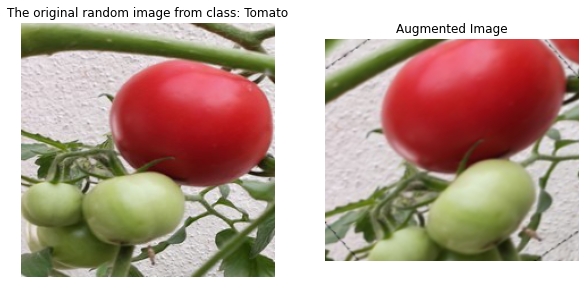

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Set random states
# random.seed(42)
# tf.random.set_seed(42)

def view_random_image():
  target_class = random.choice(train_data.class_names)
  target_dir = os.path.join(input_object, 'train' , target_class)
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + '/' + random_image

  plt.figure(figsize=(10,15))

  # Read in random image
  image = mpimg.imread(random_image_path)
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title(f'The original random image from class: {target_class}')
  plt.axis(False)


  # Now plot the augmented random image
  augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
  plt.subplot(1, 2, 2)
  plt.imshow(tf.squeeze(augmented_image/255.))
  plt.title(f'Augmented Image')
  plt.axis(False)

view_random_image()

## Creating checkpoint callback


In [10]:
checkpoint_path = os.path.join(output_object,'checkpoint_30_percent/checkpoint.ckpt')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

# Create Feature Extraction models



## Feature Extraction base model

In [11]:
from numpy import e
from tensorflow.keras import layers


# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Extract features from model
x = layers.GlobalAveragePooling2D (name='global_average_pooling_layer')(x)

outputs = layers.Dense(15, activation='softmax', name='output_layer')(x)

## Model 1: Feature Extraction

141/141 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.8671
Epoch 00001: val_loss improved from inf to 0.19451, saving model to /home/ubuntu/storage/abcli/ic_output_object_v1/checkpoint_30_percent/checkpoint.ckpt


From /home/ubuntu/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
From /home/ubuntu/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Assets written to: /home/ubuntu/storage/abcli/ic_output_object_v1/checkpoint_30_percent/checkpoint.ckpt/assets


141/141 [==============================] - 63s 447ms/step - loss: 0.7109 - accuracy: 0.8671 - val_loss: 0.1945 - val_accuracy: 0.9743


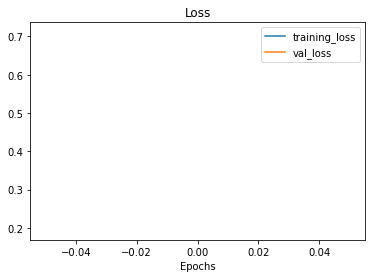

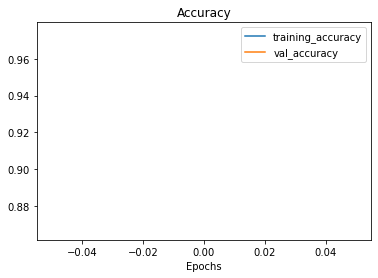

In [12]:
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_1 = model_1.fit(
    train_30_percent, 
    epochs = initial_epochs,
    steps_per_epoch=len(train_30_percent),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[checkpoint_callback]
)
plot_loss_curves(history_1)

In [13]:
model_1_results = model_1.evaluate(test_data)

94/94 [==============================] - 8s 81ms/step - loss: 0.2071 - accuracy: 0.9693


In [14]:
model_1.save_weights(checkpoint_path)

* model_1 gives great results with 99% accuracy on the full test dataset
* model_1 only uses 30% of training data, we'll use the full training set once we fine tune the model

Since model_1 has good performance we'll checkpoint it to create the fine tuned models to squeeze a little more out of our model

## Model 2: Fine tuning


In [15]:
# Load in the model
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)

### Unfreeze layers

In [16]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile our models every time we make a change)
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)

In [17]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

## Fit the model

Epoch 1/2
94/94 [==============================] - 25s 266ms/step - loss: 0.1786 - accuracy: 0.9480 - val_loss: 0.0230 - val_accuracy: 0.9940
Epoch 2/2
94/94 [==============================] - 23s 242ms/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.0167 - val_accuracy: 0.9940


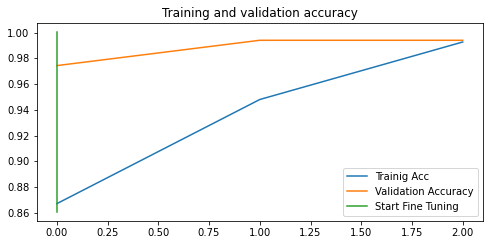

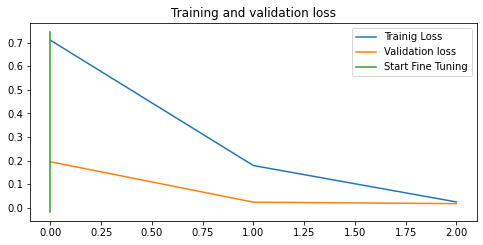

In [18]:

fine_tuned_epochs = initial_epochs + fine_tune_epochs

history_2 = model_2.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_2)

In [19]:
model_2_results = model_2.evaluate(test_data)

94/94 [==============================] - 7s 80ms/step - loss: 0.0081 - accuracy: 0.9973


In [20]:
model_1_results, model_2_results

([0.20712432265281677, 0.9693333506584167],
 [0.008104912005364895, 0.9973333477973938])

* unfreezing some layers gave us a higher percentage although it's already high from model_1

lets try one more time and we'll unfreeze more layers (30)

## Model 3: Unfreeze more layers

In [21]:
model_3 = tf.keras.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

In [22]:
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_3.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


### Fit the model


Epoch 1/2
94/94 [==============================] - 22s 238ms/step - loss: 0.2009 - accuracy: 0.9480 - val_loss: 0.0313 - val_accuracy: 0.9923
Epoch 2/2
94/94 [==============================] - 22s 234ms/step - loss: 0.0395 - accuracy: 0.9873 - val_loss: 0.0650 - val_accuracy: 0.9813


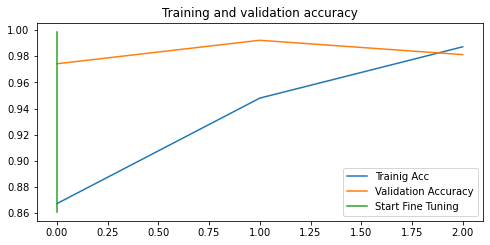

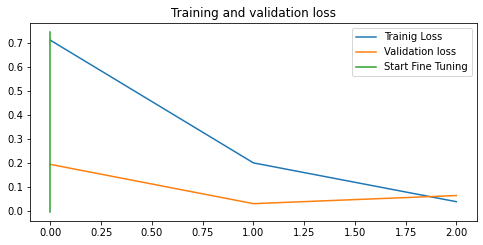

In [23]:
fine_tuned_epochs = initial_epochs + fine_tune_epochs

history_3 = model_3.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_3)

In [24]:
model_3_results = model_3.evaluate(test_data)

94/94 [==============================] - 7s 79ms/step - loss: 0.0231 - accuracy: 0.9913


# Compare Models

In [25]:
import pandas as pd
results = [model_1_results , model_2_results, model_3_results]
results_pd = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_pd

,loss,accuracy
0,0.207124,0.969333
1,0.008105,0.997333
2,0.023063,0.991333


# Summary

from the start `EfficientNetB0` gave us a very high score with only 30% of the traning data_augmentation

`model_3` gives us the best accuracy score with 30 layers of the base model unfrozen and re-fitted on our custom data

In [26]:
model_3.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 15)                19215     
Total params: 4,068,786
Trainable params: 1,515,375
Non-trainable params: 2,553,411
_________________________________________________________________


In [27]:
# END